In [2]:
import numpy as np
import pandas as pd
import csv
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow import keras
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [4]:
series2 = pd.read_csv('data/data-1.csv', header = 0, parse_dates = [0], index_col=0).squeeze("columns")
series2.head()
weekly_series2 = series2.resample('W').sum()

In [5]:
split_point2 = len(weekly_series2) - 4

In [6]:
dataset_weekly_2, validation_weekly_2 = weekly_series2[0:split_point2], weekly_series2[split_point2:]

In [7]:
print('Dataset2 %d, Validation2 %d' % (len(dataset_weekly_2), len(validation_weekly_2)))

Dataset2 64, Validation2 4


In [9]:
#определяем метрику для оценки качества модели
def buying_score(yhat, obs, dataset_length):
    score = 0
    for i in range(dataset_length):
        score += (1+yhat[i])/(1+obs[i])
    return score/dataset_length

In [15]:
#наивный прогноз
series_2=pd.read_csv('dataset_weekly2.csv', header = 0, parse_dates = [0], index_col=0).squeeze("columns")

X=series_2.values
X = X.astype('float16')
train_size = int(len(X)*0.7)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    print('Predicted=%.3f, Expected=%.3f' % (yhat, obs))
length=len(predictions)
b_score = buying_score(predictions, history, length)
print('Buying score: %.3f'%b_score)

Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=1.000
Predicted=1.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=1.000
Predicted=1.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=1.000
Predicted=1.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Predicted=0.000, Expected=0.000
Buying score: 1.000


In [16]:
#статистики по первой номеклатуре
print(series_2.describe())

count    64.000000
mean      0.203125
std       0.477417
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       2.000000
Name: count, dtype: float64


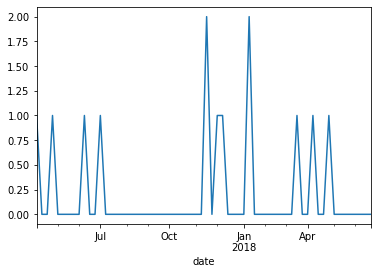

In [17]:
series_2.plot()
plt.show()

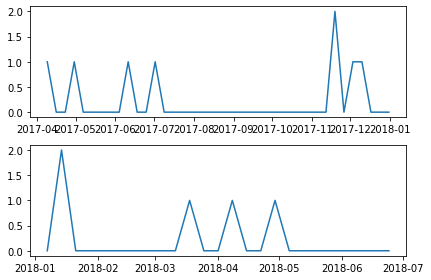

In [18]:
#проверка на сезонность
groups = series_2.groupby(series_2.index.year)
years = pd.DataFrame()
plt.figure()
n_groups = len(groups)
i=1
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i+=1
    plt.plot(group)
plt.tight_layout()
plt.show()

Сезонность не наблюдается

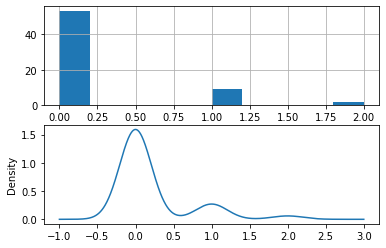

In [19]:
plt.figure(1)
plt.subplot(211)
series_2.hist()
plt.subplot(212)
series_2.plot(kind='kde')
plt.show()

Распределение не является распределнием Гаусса. Продолговатый правый сдвиг указывает на экспоненциальное распределение.

In [27]:
weeks = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis = 1)
weeks = pd.DataFrame(weeks)
print(len(weeks.columns))
weeks.columns = range(0,len(weeks.columns))

box_fig_years = go.Figure()
for i in range(0, len(weeks.columns)):
    box_fig_years.add_trace(go.Box(y=weeks[i], name=str(i)))
box_fig_years.update_layout(title_text="Сравнение распределний поставок по годам (Номенклатура 2)")
box_fig_years.show()

2


Заметных тенденций не обнаружено.

In [28]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
#оценка 1 модели
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        # диффиринцирование данных
        weeks_in_month = 4
        diff = difference(history, weeks_in_month)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, weeks_in_month)
        predictions.append(yhat)
        history.append(test[t])
    buy_score = buying_score(test, predictions, len(predictions))
    return buy_score
#оценка группы моделей по разным параметрам
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    buy_score = evaluate_arima_model(dataset, order)
                    if (buy_score < best_score) and (buy_score > 0.9 and buy_score < 1.1):
                        best_score, best_cfg = buy_score, order
                    print('ARIMA%s Buying Score=%.3f' % (order,buy_score))
                except:
                    continue
    print('Best ARIMA%s best Buying Score=%.3f' % (best_cfg, best_score))

In [29]:
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) Buying Score=1.192
ARIMA(0, 0, 1) Buying Score=1.211
ARIMA(0, 0, 2) Buying Score=1.135
ARIMA(0, 0, 3) Buying Score=1.073
ARIMA(0, 1, 0) Buying Score=inf
ARIMA(0, 1, 1) Buying Score=1.164
ARIMA(0, 1, 2) Buying Score=-0.505
ARIMA(0, 1, 3) Buying Score=1.631
ARIMA(1, 0, 0) Buying Score=1.206
ARIMA(1, 0, 1) Buying Score=1.156
ARIMA(1, 0, 2) Buying Score=1.378
ARIMA(1, 0, 3) Buying Score=1.231
ARIMA(1, 1, 0) Buying Score=inf
ARIMA(1, 1, 1) Buying Score=1.255
ARIMA(1, 1, 2) Buying Score=1.184
ARIMA(1, 1, 3) Buying Score=3.125
ARIMA(2, 0, 0) Buying Score=1.261
ARIMA(2, 0, 1) Buying Score=1.490
ARIMA(2, 0, 2) Buying Score=1.277
ARIMA(2, 0, 3) Buying Score=1.146
ARIMA(2, 1, 0) Buying Score=1.046
ARIMA(2, 1, 1) Buying Score=0.884
ARIMA(2, 1, 2) Buying Score=0.474
ARIMA(2, 1, 3) Buying Score=1.103
ARIMA(3, 0, 0) Buying Score=1.288
ARIMA(3, 0, 1) Buying Score=1.340
ARIMA(3, 0, 2) Buying Score=1.521
ARIMA(3, 0, 3) Buying Score=1.172
ARIMA(3, 1, 0) Buying Score=0.867
ARIMA(3, 1, 1) Bu

               0
count  20.000000
mean   -0.094516
std     0.627939
min    -1.669027
25%    -0.371519
50%    -0.086153
75%     0.192499
max     1.180903


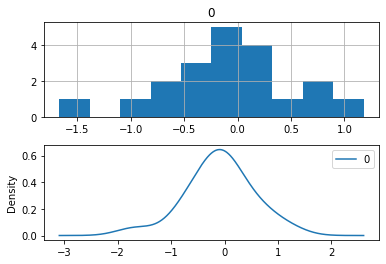

In [41]:
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    weeks_in_month = 4
    diff = difference(history, weeks_in_month)
    model = ARIMA(diff, order=(1,0,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, weeks_in_month)
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)

residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

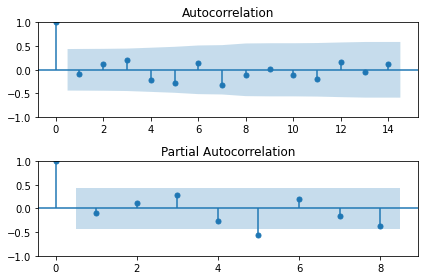

In [42]:
plt.figure()
plt.subplot(211)
plot_acf(residuals, ax=plt.gca())
plt.subplot(212)
plot_pacf(residuals, ax=plt.gca(), lags=8)
plt.tight_layout()
plt.show()

In [47]:
diff = difference(X, 4)
model = ARIMA(diff, order=(2,1,0))
model_fit = model.fit()
model_fit.save('model_2.pkl')

In [48]:
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(weekly_series2.values, yhat, 4)
print('Predicted: %.3f' % yhat)

Predicted: -0.000


>Predicted=-0.000, Expected=  0
>Predicted=0.000, Expected=  0
>Predicted=0.000, Expected=  0
>Predicted=2.000, Expected=  2
Buying score: 1.000


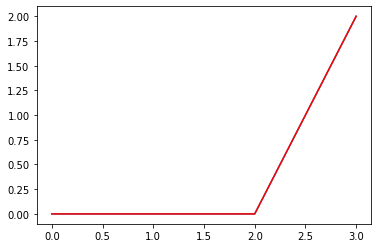

In [49]:
y = validation_weekly_2.values
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, 4)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    weeks_in_month = 4
    diff = difference(history, weeks_in_month)
    model = ARIMA(diff, order=(2,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, weeks_in_month)
    predictions.append(yhat)
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
b_score = buying_score(y, predictions, len(predictions))
print('Buying score: %.3f' % b_score)
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()